<a href="https://colab.research.google.com/github/1hamzaiqbal/satclip/blob/main/hamza/00_satclip_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SatCLIP Effective Resolution Testing

This notebook tests the setup and compares L=10 vs L=40 SatCLIP models.

**Goal**: Verify we can load models and begin investigating effective spatial resolution.

For better performance, go to `Runtime -> Change runtime type` and select `T4 GPU`.

## 1. Setup

In [1]:
# Clone SatCLIP repository (run this in Colab)
!rm -rf sample_data .config satclip 2>/dev/null
!git clone https://github.com/1hamzaiqbal/satclip.git

Cloning into 'satclip'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 298 (delta 94), reused 101 (delta 88), pack-reused 174 (from 1)
Receiving objects: 100% (298/298), 76.80 MiB | 16.38 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Updating files: 100% (81/81), done.


In [2]:
# Install dependencies
!pip install lightning --quiet
!pip install rasterio --quiet
!pip install torchgeo --quiet
!pip install huggingface_hub --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 124.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.8/241.8 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import sys
sys.path.append('./satclip/satclip')

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from load import get_satclip

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


## 2. Load Both L=10 and L=40 Models

In [4]:
# Load L=10 model (lower resolution)
print("Loading L=10 model...")
model_l10 = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L10", "satclip-vit16-l10.ckpt"),
    device=device,
)
model_l10.eval()
print("L=10 model loaded!")

# Load L=40 model (higher resolution)
print("\nLoading L=40 model...")
model_l40 = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"),
    device=device,
)
model_l40.eval()
print("L=40 model loaded!")

Loading L=10 model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


satclip-vit16-l10.ckpt:   0%|          | 0.00/103M [00:00<?, ?B/s]

using pretrained moco vit16
Downloading: "https://hf.co/torchgeo/vit_small_patch16_224_sentinel2_all_moco/resolve/1cb683f6c14739634cdfaaceb076529adf898c74/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth" to /root/.cache/torch/hub/checkpoints/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth


100%|██████████| 86.5M/86.5M [00:00<00:00, 275MB/s]


L=10 model loaded!

Loading L=40 model...


satclip-vit16-l40.ckpt:   0%|          | 0.00/121M [00:00<?, ?B/s]

using pretrained moco vit16
L=40 model loaded!


In [5]:
# Inspect model architecture
print("L=10 Location Encoder:")
print(model_l10)
print("\n" + "="*50 + "\n")
print("L=40 Location Encoder:")
print(model_l40)

L=10 Location Encoder:
LocationEncoder(
  (posenc): SphericalHarmonics()
  (nnet): SirenNet(
    (layers): ModuleList(
      (0-1): 2 x Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  )
)


L=40 Location Encoder:
LocationEncoder(
  (posenc): SphericalHarmonics()
  (nnet): SirenNet(
    (layers): ModuleList(
      (0-1): 2 x Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  )
)


## 3. Test Basic Embedding Generation

In [6]:
# Test with some well-known locations
test_locations = torch.tensor([
    [-122.4194, 37.7749],   # San Francisco
    [-74.0060, 40.7128],    # New York
    [0.1276, 51.5074],      # London
    [139.6917, 35.6895],    # Tokyo
    [77.2090, 28.6139],     # Delhi
    [-43.1729, -22.9068],   # Rio de Janeiro
]).double()

location_names = ['San Francisco', 'New York', 'London', 'Tokyo', 'Delhi', 'Rio de Janeiro']

with torch.no_grad():
    emb_l10 = model_l10(test_locations.to(device)).cpu()
    emb_l40 = model_l40(test_locations.to(device)).cpu()

print(f"L=10 embeddings shape: {emb_l10.shape}")
print(f"L=40 embeddings shape: {emb_l40.shape}")

L=10 embeddings shape: torch.Size([6, 256])
L=40 embeddings shape: torch.Size([6, 256])


## 4. Embedding Similarity Analysis

Compare how similar the embeddings are between locations for L=10 vs L=40.

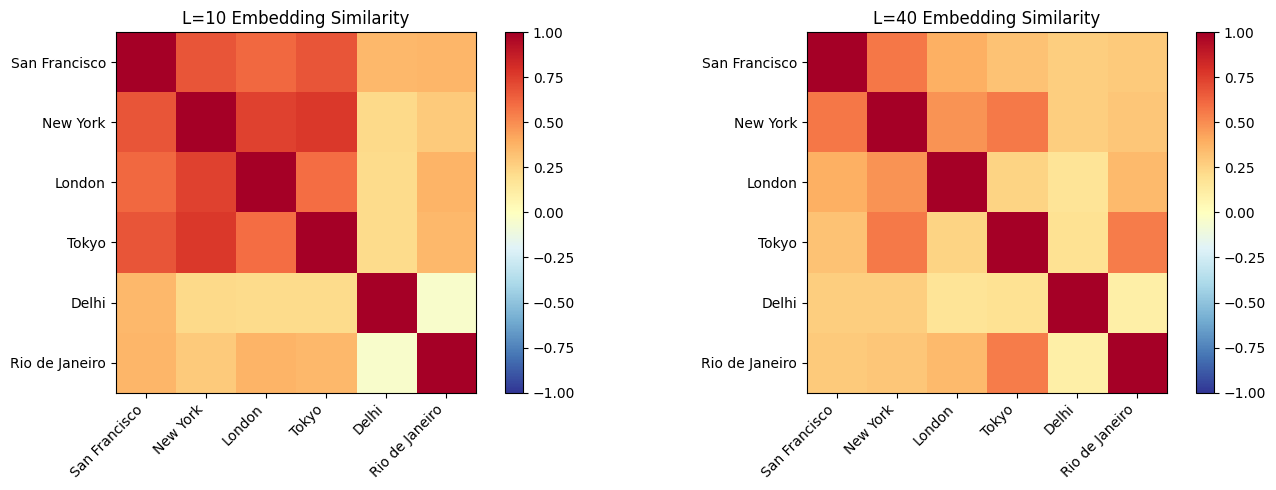

In [7]:
def compute_similarity_matrix(embeddings):
    """Compute pairwise cosine similarity matrix."""
    # Normalize embeddings
    norm_emb = F.normalize(embeddings, p=2, dim=1)
    # Compute similarity matrix
    sim_matrix = torch.mm(norm_emb, norm_emb.t())
    return sim_matrix.numpy()

sim_l10 = compute_similarity_matrix(emb_l10.float())
sim_l40 = compute_similarity_matrix(emb_l40.float())

# Plot similarity matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im1 = axes[0].imshow(sim_l10, cmap='RdYlBu_r', vmin=-1, vmax=1)
axes[0].set_title('L=10 Embedding Similarity')
axes[0].set_xticks(range(len(location_names)))
axes[0].set_yticks(range(len(location_names)))
axes[0].set_xticklabels(location_names, rotation=45, ha='right')
axes[0].set_yticklabels(location_names)
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(sim_l40, cmap='RdYlBu_r', vmin=-1, vmax=1)
axes[1].set_title('L=40 Embedding Similarity')
axes[1].set_xticks(range(len(location_names)))
axes[1].set_yticks(range(len(location_names)))
axes[1].set_xticklabels(location_names, rotation=45, ha='right')
axes[1].set_yticklabels(location_names)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

## 5. Distance-Based Resolution Test

Key question: At what distance do embeddings start to differ significantly?

We'll generate points at varying distances from a reference and measure similarity decay.

In [8]:
def haversine_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance in kilometers."""
    R = 6371  # Earth's radius in km

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def generate_points_at_distances(ref_lon, ref_lat, distances_km, n_samples=8):
    """
    Generate points at specified distances from reference in different directions.
    Returns (N_distances, n_samples, 2) array of [lon, lat] coordinates.
    """
    R = 6371  # Earth's radius in km
    points = []

    for dist in distances_km:
        dist_points = []
        for i in range(n_samples):
            bearing = 2 * np.pi * i / n_samples  # Evenly spaced bearings

            # Calculate new point using spherical geometry
            lat1 = np.radians(ref_lat)
            lon1 = np.radians(ref_lon)
            d = dist / R

            lat2 = np.arcsin(np.sin(lat1) * np.cos(d) +
                           np.cos(lat1) * np.sin(d) * np.cos(bearing))
            lon2 = lon1 + np.arctan2(np.sin(bearing) * np.sin(d) * np.cos(lat1),
                                     np.cos(d) - np.sin(lat1) * np.sin(lat2))

            dist_points.append([np.degrees(lon2), np.degrees(lat2)])
        points.append(dist_points)

    return np.array(points)

# Test with San Francisco as reference
ref_lon, ref_lat = -122.4194, 37.7749

# Distances to test (in km) - logarithmic scale from 1km to 10000km
distances = [1, 5, 10, 50, 100, 500, 1000, 5000]

points = generate_points_at_distances(ref_lon, ref_lat, distances, n_samples=8)
print(f"Generated points shape: {points.shape}")  # (n_distances, n_samples, 2)

Generated points shape: (8, 8, 2)


In [9]:
# Compute embeddings for reference and all distance points
ref_coord = torch.tensor([[ref_lon, ref_lat]]).double()

with torch.no_grad():
    ref_emb_l10 = model_l10(ref_coord.to(device)).cpu()
    ref_emb_l40 = model_l40(ref_coord.to(device)).cpu()

# Compute similarities at each distance
sims_l10 = []
sims_l40 = []

for i, dist in enumerate(distances):
    dist_coords = torch.tensor(points[i]).double()

    with torch.no_grad():
        emb_l10 = model_l10(dist_coords.to(device)).cpu()
        emb_l40 = model_l40(dist_coords.to(device)).cpu()

    # Compute cosine similarity with reference
    sim_l10 = F.cosine_similarity(ref_emb_l10.float(), emb_l10.float()).mean().item()
    sim_l40 = F.cosine_similarity(ref_emb_l40.float(), emb_l40.float()).mean().item()

    sims_l10.append(sim_l10)
    sims_l40.append(sim_l40)

    print(f"Distance: {dist:5d} km | L=10 similarity: {sim_l10:.4f} | L=40 similarity: {sim_l40:.4f}")

Distance:     1 km | L=10 similarity: 1.0000 | L=40 similarity: 1.0000
Distance:     5 km | L=10 similarity: 1.0000 | L=40 similarity: 0.9997
Distance:    10 km | L=10 similarity: 0.9999 | L=40 similarity: 0.9988
Distance:    50 km | L=10 similarity: 0.9986 | L=40 similarity: 0.9711
Distance:   100 km | L=10 similarity: 0.9943 | L=40 similarity: 0.9002
Distance:   500 km | L=10 similarity: 0.8898 | L=40 similarity: 0.3035
Distance:  1000 km | L=10 similarity: 0.7336 | L=40 similarity: 0.0806
Distance:  5000 km | L=10 similarity: 0.3055 | L=40 similarity: 0.0790


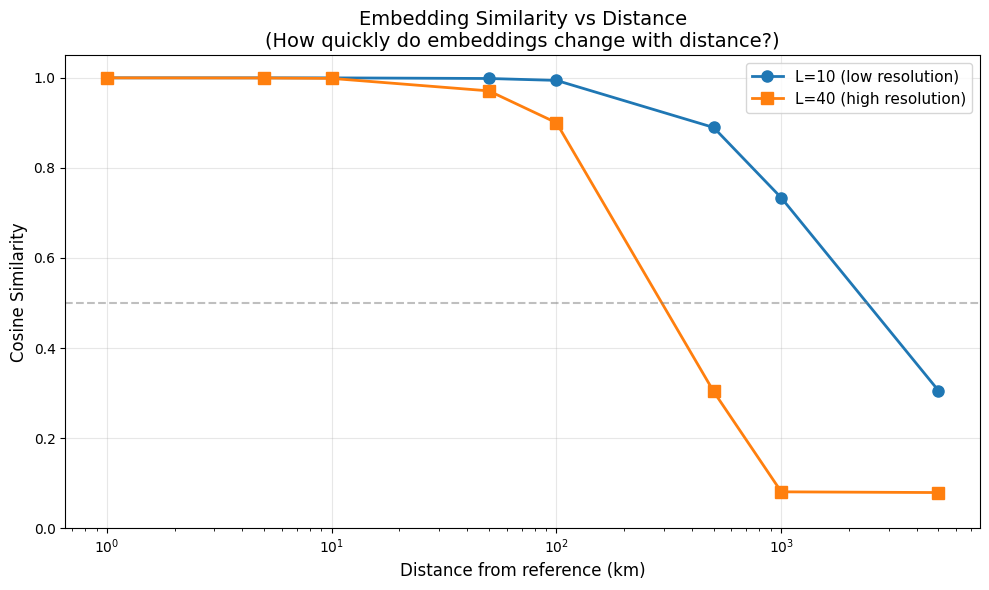


Interpretation:
- Steeper drop = model can distinguish closer locations = higher effective resolution
- L=40 should show steeper drop at short distances if it has higher resolution


In [10]:
# Plot similarity vs distance
plt.figure(figsize=(10, 6))

plt.semilogx(distances, sims_l10, 'o-', label='L=10 (low resolution)', linewidth=2, markersize=8)
plt.semilogx(distances, sims_l40, 's-', label='L=40 (high resolution)', linewidth=2, markersize=8)

plt.xlabel('Distance from reference (km)', fontsize=12)
plt.ylabel('Cosine Similarity', fontsize=12)
plt.title('Embedding Similarity vs Distance\n(How quickly do embeddings change with distance?)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

# Add reference lines
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% similarity')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Steeper drop = model can distinguish closer locations = higher effective resolution")
print("- L=40 should show steeper drop at short distances if it has higher resolution")

## 6. Checkerboard Resolution Test (Foundation)

Create a synthetic binary classification task where class is determined by a checkerboard pattern.
The cell size of the checkerboard determines the required spatial resolution.

In [11]:
def create_checkerboard_dataset(cell_size_deg, n_samples=5000, bounds=(-180, 180, -60, 60)):
    """
    Create a checkerboard classification dataset.

    Args:
        cell_size_deg: Size of checkerboard cells in degrees
        n_samples: Number of samples to generate
        bounds: (lon_min, lon_max, lat_min, lat_max)

    Returns:
        coords: (N, 2) tensor of [lon, lat]
        labels: (N,) tensor of 0/1 labels
    """
    lon_min, lon_max, lat_min, lat_max = bounds

    # Random sample locations
    lons = np.random.uniform(lon_min, lon_max, n_samples)
    lats = np.random.uniform(lat_min, lat_max, n_samples)

    # Assign labels based on checkerboard pattern
    cell_x = (lons / cell_size_deg).astype(int)
    cell_y = (lats / cell_size_deg).astype(int)
    labels = (cell_x + cell_y) % 2

    coords = torch.tensor(np.stack([lons, lats], axis=1)).double()
    labels = torch.tensor(labels).long()

    return coords, labels

# Test with different cell sizes
# Note: 1 degree latitude ≈ 111 km
cell_sizes = [45, 20, 10, 5, 2, 1, 0.5]  # degrees
approx_km = [c * 111 for c in cell_sizes]  # approximate km

print("Cell sizes to test:")
for deg, km in zip(cell_sizes, approx_km):
    print(f"  {deg}° ≈ {km:.0f} km")

Cell sizes to test:
  45° ≈ 4995 km
  20° ≈ 2220 km
  10° ≈ 1110 km
  5° ≈ 555 km
  2° ≈ 222 km
  1° ≈ 111 km
  0.5° ≈ 56 km


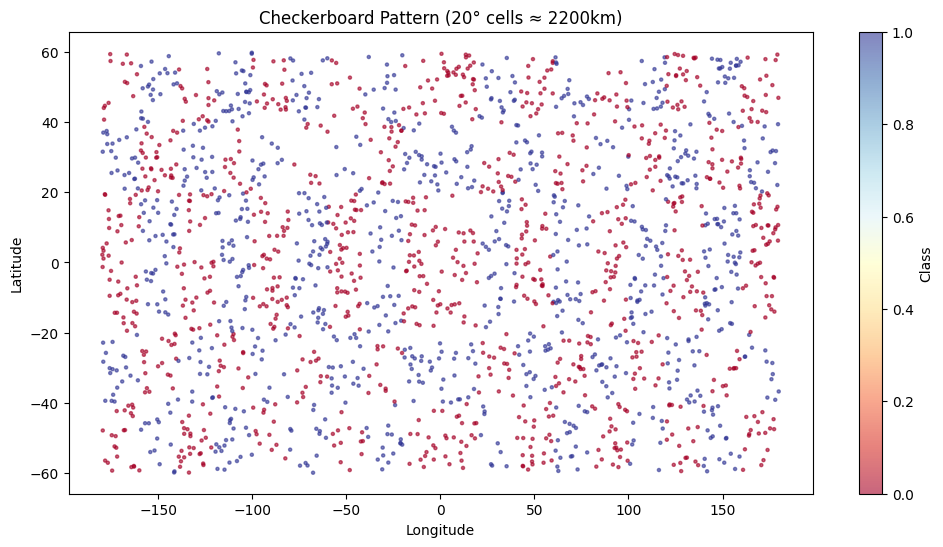

In [12]:
# Visualize a checkerboard pattern
coords_viz, labels_viz = create_checkerboard_dataset(cell_size_deg=20, n_samples=2000)

plt.figure(figsize=(12, 6))
scatter = plt.scatter(coords_viz[:, 0], coords_viz[:, 1], c=labels_viz,
                      cmap='RdYlBu', s=5, alpha=0.6)
plt.colorbar(scatter, label='Class')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Checkerboard Pattern (20° cells ≈ 2200km)')
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def evaluate_checkerboard(model, cell_size_deg, n_samples=5000, model_name="Model"):
    """
    Evaluate model's ability to solve checkerboard classification.
    """
    # Create dataset
    coords, labels = create_checkerboard_dataset(cell_size_deg, n_samples)

    # Get embeddings
    with torch.no_grad():
        embeddings = model(coords.to(device)).cpu().numpy()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels.numpy(), test_size=0.3, random_state=42
    )

    # Train simple classifier
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Run checkerboard test for both models at different resolutions
results_l10 = []
results_l40 = []

print("Running checkerboard resolution test...\n")
print(f"{'Cell Size':>12} | {'≈ km':>8} | {'L=10 Acc':>10} | {'L=40 Acc':>10}")
print("-" * 50)

for cell_size in cell_sizes:
    acc_l10 = evaluate_checkerboard(model_l10, cell_size, n_samples=3000)
    acc_l40 = evaluate_checkerboard(model_l40, cell_size, n_samples=3000)

    results_l10.append(acc_l10)
    results_l40.append(acc_l40)

    km_approx = cell_size * 111
    print(f"{cell_size:>10.1f}° | {km_approx:>7.0f} | {acc_l10:>10.2%} | {acc_l40:>10.2%}")

Running checkerboard resolution test...

   Cell Size |     ≈ km |   L=10 Acc |   L=40 Acc
--------------------------------------------------
      45.0° |    4995 |     93.67% |     63.67%
      20.0° |    2220 |     79.00% |     56.56%
      10.0° |    1110 |     56.11% |     57.22%
       5.0° |     555 |     49.78% |     55.00%
       2.0° |     222 |     49.44% |     49.56%
       1.0° |     111 |     46.44% |     49.00%
       0.5° |      56 |     50.78% |     51.11%


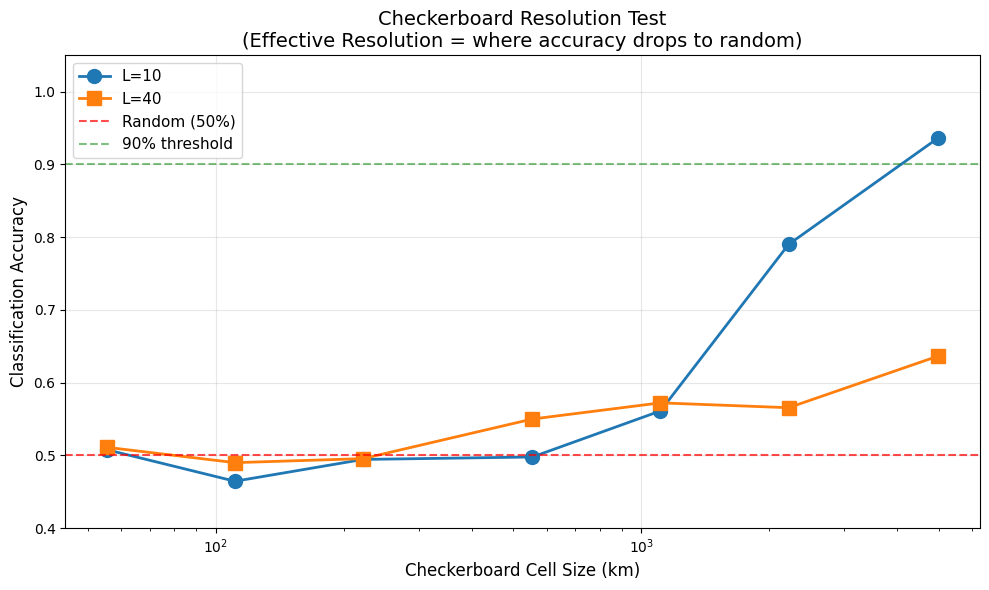


Interpretation:
- Where accuracy drops to ~50% = effective resolution limit
- L=40 should maintain high accuracy at smaller cell sizes than L=10


In [14]:
# Plot checkerboard results
plt.figure(figsize=(10, 6))

plt.plot(approx_km, results_l10, 'o-', label='L=10', linewidth=2, markersize=10)
plt.plot(approx_km, results_l40, 's-', label='L=40', linewidth=2, markersize=10)

plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random (50%)')
plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='90% threshold')

plt.xscale('log')
plt.xlabel('Checkerboard Cell Size (km)', fontsize=12)
plt.ylabel('Classification Accuracy', fontsize=12)
plt.title('Checkerboard Resolution Test\n(Effective Resolution = where accuracy drops to random)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0.4, 1.05)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Where accuracy drops to ~50% = effective resolution limit")
print("- L=40 should maintain high accuracy at smaller cell sizes than L=10")

## 7. Summary & Next Steps

In [15]:
print("="*60)
print("SUMMARY")
print("="*60)
print(f"\nModels tested:")
print(f"  - L=10: {model_l10}")
print(f"  - L=40: {model_l40}")

print(f"\nEmbedding dimension: {emb_l10.shape[1]}")

print("\nKey findings from checkerboard test:")
for i, (cell_size, km, acc10, acc40) in enumerate(zip(cell_sizes, approx_km, results_l10, results_l40)):
    diff = acc40 - acc10
    better = "L=40" if diff > 0.01 else ("L=10" if diff < -0.01 else "~same")
    print(f"  {km:>6.0f} km cells: L=10={acc10:.1%}, L=40={acc40:.1%} ({better})")

print("\n" + "="*60)
print("NEXT STEPS")
print("="*60)
print("""
1. Run on finer checkerboard resolutions (0.1°, 0.05°)
2. Test with real ecoregion data (Level 1, 2, 3)
3. Test with US Census population density data
4. Explore intermediate L values if needed
""")

SUMMARY

Models tested:
  - L=10: LocationEncoder(
  (posenc): SphericalHarmonics()
  (nnet): SirenNet(
    (layers): ModuleList(
      (0-1): 2 x Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  )
)
  - L=40: LocationEncoder(
  (posenc): SphericalHarmonics()
  (nnet): SirenNet(
    (layers): ModuleList(
      (0-1): 2 x Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  )
)

Embedding dimension: 256

Key findings from checkerboard test:
    4995 km cells: L=10=93.7%, L=40=63.7% (L=10)
    2220 km cells: L=10=79.0%, L=40=56.6% (L=10)
    1110 km cells: L=10=56.1%, L=40=57.2% (L=40)
     555 km cells: L=10=49.8%, L=40=55.0% (L=40)
     222 km cells: L=10=49.4%, L=40=49.6% (~same)
     111 km cells: L=10=46.4%, L=40=49.0% (L=40)
      56 km cells: L=10=50.8%, L=40=51.1% (~same)

NEXT STEPS

1. Run on finer checkerboard resolutions (0.1°, 0.05°)
2. Test with real

---

## Appendix: Model Details

In [16]:
# Count parameters in each model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"L=10 parameters: {count_parameters(model_l10):,}")
print(f"L=40 parameters: {count_parameters(model_l40):,}")
print(f"\nParameter ratio (L=40/L=10): {count_parameters(model_l40)/count_parameters(model_l10):.2f}x")

L=10 parameters: 445,696
L=40 parameters: 1,213,696

Parameter ratio (L=40/L=10): 2.72x
